In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from datetime import datetime, timedelta
import sys
sys.path.append("/Users/mprange/PycharmProjects/flight_phase_seperation/")

from typhon.plots import worldmap
import FlightPhaseTools as fpt
from ResearchFlight import ResearchFlight
from ResearchFlightSegment import ResearchFlightSegment

# Load data into xarray datasets using typhon FileSet objects.

In [2]:
bahamas = xr.open_dataset('/Users/mprange/Desktop/halo_unified/unified/bahamas_20200215_v0.4.nc')
dropsondes = xr.open_dataset('/Users/mprange/Desktop/halo_unified/unified/dropsondes_20200215_v0.4.nc')

# Determine the timestamps of the different flight phases using the FlightPhaseTools module.

In [191]:
takeoff = 0
touchdown = len(bahamas['time']) - 1

#circle 1,2
enter_c1_ds = fpt.ds_timestamp_ind(bahamas, dropsondes,  0)
enter_c1 = fpt.timestamp_ind_1min_prior(bahamas, enter_c1_ds)
exit_c1 = fpt.exit_circle_timestamp_ind(bahamas, enter_c1, search_interval_sec=4500)-97

enter_c2_ds = fpt.ds_timestamp_ind(bahamas, dropsondes, 12)
enter_c2 = fpt.timestamp_ind_1min_prior(bahamas, enter_c2_ds)
exit_c2 = fpt.max_timestamp_ind(bahamas, 'heading', 
                       slice('2020-02-15T17:40:00', '2020-02-15T17:50:00'), order=1000)
#leg1 (towards NTAS)
min_roll_before_leg1 = fpt.min_timestamp_ind(bahamas, 'roll', 
                       slice('2020-02-15T17:45:00', '2020-02-15T18:00:00'), order=1000)

enter_leg1 = fpt.find_first_value_after_ts_ind(bahamas, 'roll', min_roll_before_leg1, 0., 0.05) - 55

min_roll_after_leg1 = fpt.min_timestamp_ind(bahamas, 'roll', 
                      slice('2020-02-15T18:00:00', '2020-02-15T18:20:00'), order=1000)

exit_leg1 = fpt.find_first_value_before_ts_ind(bahamas, 'roll', min_roll_after_leg1, 0., 0.01) + 44

#circle 3
enter_c3_ds = fpt.ds_timestamp_ind(bahamas, dropsondes, 18)
enter_c3 = fpt.timestamp_ind_1min_prior(bahamas, enter_c3_ds) + 55
# enter_c3 = fpt.max_timestamp_ind(bahamas, 'heading',
#                                  slice(bahamas['time'][exit_leg1], '2020-02-15T18:20:00'), order=1000)
exit_c3 = fpt.exit_circle_timestamp_ind(bahamas, enter_c3, search_interval_sec=4000) + 2

#leg2 (return NTAS)
max_roll_before_leg2 = fpt.max_timestamp_ind(bahamas, 'roll', 
                       slice('2020-02-15T19:20:00', '2020-02-15T19:40:00'), order=1000)

enter_leg2 = fpt.find_first_value_after_ts_ind(bahamas, 'roll', max_roll_before_leg2, 0., 0.05) - 70

min_roll_after_leg2 = fpt.min_timestamp_ind(bahamas, 'roll', 
                      slice('2020-02-15T19:50:00', '2020-02-15T20:00:00'), order=1000)

exit_leg2 = fpt.find_first_value_before_ts_ind(bahamas, 'roll', min_roll_after_leg2, 0., 0.05) + 22

#2nd circle set
###############
exit_c4  = fpt.max_timestamp_ind(bahamas, 'heading', 
           slice('2020-02-15T21:05:00', '2020-02-15T21:25:00'), order=1000)
enter_c4 = fpt.enter_circle_timestamp_ind_given_end(bahamas, exit_c4, search_interval_sec=4500) - 4
min_heading_before_c5 = fpt.min_timestamp_ind(bahamas, 'heading', 
                                             slice('2020-02-15T21:35:00', bahamas['time'][enter_c5]), order=1000)
enter_c5_ds = fpt.ds_timestamp_ind(bahamas, dropsondes, 31)
enter_c5 = fpt.timestamp_ind_1min_prior(bahamas, enter_c5_ds)
exit_c5  = fpt.exit_circle_timestamp_ind(bahamas, enter_c5, search_interval_sec=3600) + 14
enter_c6_ds = fpt.ds_timestamp_ind(bahamas, dropsondes, 43)
enter_c6 = fpt.timestamp_ind_1min_prior(bahamas, enter_c6_ds)
bahamas["altitude_dt"] = (['time'], np.append(np.diff(bahamas["altitude"]),0))
min_dzdt_before_lidar_cal = fpt.min_timestamp_ind(bahamas, 'altitude_dt', 
                            slice('2020-02-15T23:20:00', '2020-02-15T23:40:00'), order=1000)
exit_c6 = fpt.find_first_value_before_ts_ind(bahamas, 'altitude_dt', min_dzdt_before_lidar_cal, 0., 0.05) + 337

#lidar_cal
enter_lidar_cal = fpt.find_first_value_after_ts_ind(bahamas, 'altitude_dt', min_dzdt_before_lidar_cal, 0., 0.05)
min_dzdt_after_lidar_cal = fpt.min_timestamp_ind(bahamas, 'altitude_dt', 
                            slice('2020-02-15T23:55:00', '2020-02-16T00:05:00'), order=1000)

exit_lidar_cal = fpt.find_first_value_before_ts_ind(bahamas, 'altitude_dt', min_dzdt_after_lidar_cal, 0., 0.05) + 2


ts_ind_list = [takeoff, 
               enter_c1, exit_c1, 
               enter_c2, exit_c2,
               enter_leg1, exit_leg1, 
               enter_c3, exit_c3,
               enter_leg2, exit_leg2,
               enter_c4, exit_c4, 
               min_heading_before_c5,
               enter_c5, exit_c5,
               enter_c6, exit_c6,
               enter_lidar_cal, exit_lidar_cal, 
               touchdown]
label_list = ["takeoff", 
              "enter_c1", "exit_c1", 
              "enter_c2", "exit_c2", 
              "enter_leg1", "exit_leg1", 
              "enter_c3", "exit_c3",
              "enter_leg2", "exit_leg2",
              "enter_c4", "exit_c4", 
              "min_heading_before_c5",
              "enter_c5", "exit_c5",
              "enter_c6", "exit_c6",
              "enter_lidar_cal", "exit_lidar_cal", 
              "touchdown"]

In [6]:
#create markers for every dropsonde
#--> helps to see the individual circles
#only execute if needed!
ts_ind_list = []
label_list = np.arange(1,len(dropsondes["launch_time"])+1)
for i in range(len(dropsondes["launch_time"])):
    ts_ind_list.append(fpt.ds_timestamp_ind(bahamas, dropsondes,  i))

In [154]:
bahamas['heading'][enter_c6] - bahamas['heading'][exit_c6]

<xarray.DataArray 'heading' ()>
array(55.67320251)

# Create basic timeseries of bahamas data with markers for determined timestamps to manually evaluate the validity of the timestamps.

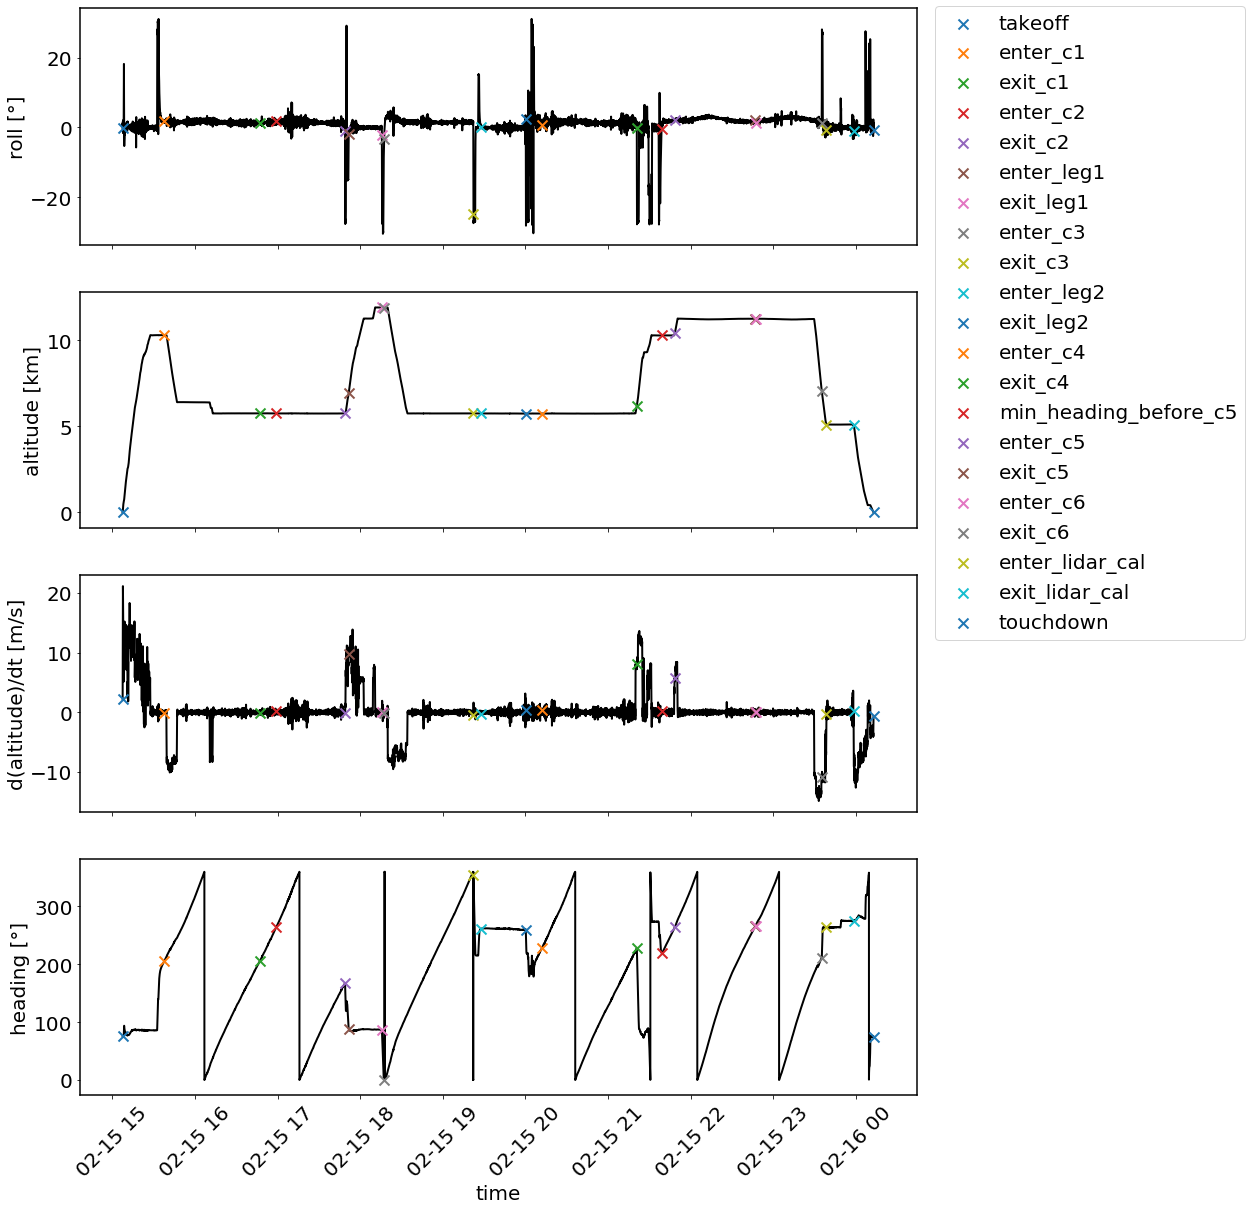

In [153]:
fig, ax = fpt.plot_bahamas_timeseries(bahamas, ts_ind_list, label_list)

# Create a ResearchFlight object to represent the flight meta data.

In [192]:
RF14 = ResearchFlight(name=f"RF{bahamas.attrs['flight_number']}",
                      mission=bahamas.attrs['mission'],
                      flight_id='HALO-0215',
                      contacts=[
                          {
                              'name': 'Marc Prange', 
                              'email': 'marc.prange@uni-hamburg.de',
                              'tags': ['dataset creator'],
                          },
                          {
                              'name': 'Sandrine Bony',
                              'email': 'bony@lmd.jussieu.fr',
                              'tags': ['flight PI']
                          }
                      ],
                      date=fpt.dt64_to_dt(bahamas['time'][takeoff].values).date(),
                      flight_report='https://observations.ipsl.fr/aeris/eurec4a-data/REPORTS/HALO/2020/20200215/HALO-0215.pdf',
                      takeoff=fpt.dt64_to_dt(bahamas['time'][takeoff].values),
                      landing=fpt.dt64_to_dt(bahamas['time'][touchdown].values),
                      events=[],
                      remarks=['First two circles near Barbados. Excursion to NTAS. Third circle at NTAS location.'
                               'Last three circles again near Barbados.',
                               'Fewer dropsondes launched than usual because of the '
                               'availibility at this stage of the campaign.',
                               '**Only one dropsonde during circle 5!**',
                               'Thick and persistent altostratus layer (top at ~9km) '
                               'covering the area from Barbados to NTAS.',
                               'Beneath the altostratus layer shallow clouds and stratiform layers were present.',
                               'Flight went above and below the altostratus layer.',
                               '**See flight-report for more information.**'],
)

In [90]:
bahamas['heading'][enter_c1] - bahamas['heading'][exit_c1-1]

<xarray.DataArray 'heading' ()>
array(0.08126831)

# Store the flight phase information in ResearchFlightSegment objects.

In [193]:
circle1 = ResearchFlightSegment(kinds=['circle'],
                                name='circle 1',
                                start=fpt.dt64_to_dt(bahamas["time"][enter_c1].values),
                                end=fpt.dt64_to_dt(bahamas['time'][exit_c1].values),
                                good_dropsondes=12,
                                irregularities=["descent from FL320 to FL180", "circle lasts 69 minutes"],
                                segment_id=f"{RF14.flight_id}_c1"
                               )
circleBreak1to2 = ResearchFlightSegment(kinds=['circle_break'],
                                        name='circle break 1',
                                        start=fpt.dt64_to_dt(bahamas["time"][exit_c1].values),
                                        end=fpt.dt64_to_dt(bahamas['time'][enter_c2].values),
                                        irregularities=[],
                                        segment_id=f"{RF14.flight_id}_cb1"
                                       )
circle2 = ResearchFlightSegment(kinds=['circle'],
                                name='circle 2',
                                start=fpt.dt64_to_dt(bahamas["time"][enter_c2].values),
                                end=fpt.dt64_to_dt(bahamas['time'][exit_c2].values),
                                good_dropsondes=6,
                                irregularities=['early circle exit after 263 degrees'],
                                segment_id=f"{RF14.flight_id}_c2"
                               )
leg1 = ResearchFlightSegment(kinds=['straight_leg'],
                             name='leg 1 from circle east to NTAS',
                             start=fpt.dt64_to_dt(bahamas["time"][enter_leg1].values),
                             end=fpt.dt64_to_dt(bahamas['time'][exit_leg1].values),
                             irregularities=['change FL180 to FL370'],
                             segment_id=f"{RF14.flight_id}_sl1"
                            )
circle3 = ResearchFlightSegment(kinds=['circle'],
                                name='circle 3',
                                start=fpt.dt64_to_dt(bahamas["time"][enter_c3].values),
                                end=fpt.dt64_to_dt(bahamas['time'][exit_c3].values),
                                good_dropsondes=12,
                                irregularities=['starts 6 seconds prior to first dropsonde'],
                                segment_id=f"{RF14.flight_id}_c3"
                               )
leg2 = ResearchFlightSegment(kinds=['straight_leg'],
                             name='leg 2 from NTAS to circle east',
                             start=fpt.dt64_to_dt(bahamas["time"][enter_leg2].values),
                             end=fpt.dt64_to_dt(bahamas['time'][exit_leg2].values),
                             irregularities=[],
                             segment_id=f"{RF14.flight_id}_sl2"
                            )
circle4 = ResearchFlightSegment(kinds=['circle'],
                                name='circle 4',
                                start=fpt.dt64_to_dt(bahamas["time"][enter_c4].values),
                                end=fpt.dt64_to_dt(bahamas['time'][exit_c4].values),
                                good_dropsondes=1,
                                irregularities=['does not start 1 minute prior to dropsonde', 
                                                'only one dropsonde at the end'],
                                segment_id=f"{RF14.flight_id}_c4"
                               )
circleBreak4to5 = ResearchFlightSegment(kinds=['circle_break'],
                                        name='circle break 2',
                                        start=fpt.dt64_to_dt(bahamas["time"][min_heading_before_c5].values),
                                        end=fpt.dt64_to_dt(bahamas['time'][enter_c5].values),
                                        irregularities=['excludes period of circle deviation'
                                                        'between circle 4 and circle 5'],
                                        segment_id=f"{RF14.flight_id}_cb2"
                                       )
circle5 = ResearchFlightSegment(kinds=['circle'],
                                name='circle 5',
                                start=fpt.dt64_to_dt(bahamas["time"][enter_c5].values),
                                end=fpt.dt64_to_dt(bahamas['time'][exit_c5].values),
                                good_dropsondes=12,
                                irregularities=['ascend from 10.4 km to 11.2 km at circle start'],
                                segment_id=f"{RF14.flight_id}_c5"
                               )
circleBreak5to6 = ResearchFlightSegment(kinds=['circle_break'],
                                        name='circle break 3',
                                        start=fpt.dt64_to_dt(bahamas["time"][exit_c5].values),
                                        end=fpt.dt64_to_dt(bahamas['time'][enter_c6].values),
                                        irregularities=[],
                                        segment_id=f"{RF14.flight_id}_cb3"
                                       )
circle6 = ResearchFlightSegment(kinds=['circle'],
                                name='circle 6',
                                start=fpt.dt64_to_dt(bahamas["time"][enter_c6].values),
                                end=fpt.dt64_to_dt(bahamas['time'][exit_c6].values),
                                good_dropsondes=7,
                                irregularities=['early circle exit after 304 degrees'],
                                segment_id=f"{RF14.flight_id}_c6",
                               )
lidar_cal = ResearchFlightSegment(kinds=['lidar_leg'],
                                  name='lidar leg',
                                  start=fpt.dt64_to_dt(bahamas["time"][enter_lidar_cal].values),
                                  end=fpt.dt64_to_dt(bahamas['time'][exit_lidar_cal].values),
                                  irregularities=[],
                                  segment_id=f"{RF14.flight_id}_ll1",
                                 )
circling1 = ResearchFlightSegment(kinds=['circling'],
                                name='circling 1',
                                start=fpt.dt64_to_dt(bahamas["time"][enter_c1].values),
                                end=fpt.dt64_to_dt(bahamas['time'][exit_c2].values),
                                good_dropsondes=circle1.good_dropsondes + circle2.good_dropsondes,
                                irregularities=["circle1: descent from FL320 to FL180", 
                                                "circle1: lasts 69 minutes",
                                                "circle2: early circle exit after 263 degrees"],
                                segment_id=f"{RF14.flight_id}_o1",
                               )
circling2 = ResearchFlightSegment(kinds=['circling'],
                                name='circling 2',
                                start=fpt.dt64_to_dt(bahamas["time"][enter_c3].values),
                                end=fpt.dt64_to_dt(bahamas['time'][exit_c3].values),
                                good_dropsondes=circle3.good_dropsondes,
                                irregularities=["circle3: starts 6 seconds prior to first dropsonde"],
                                segment_id=f"{RF14.flight_id}_o2",
                               )
circling3 = ResearchFlightSegment(kinds=['circling'],
                                name='circling 3',
                                start=fpt.dt64_to_dt(bahamas["time"][enter_c4].values),
                                end=fpt.dt64_to_dt(bahamas['time'][exit_c6].values),
                                good_dropsondes=circle4.good_dropsondes + circle5.good_dropsondes + \
                                                circle6.good_dropsondes,
                                irregularities=["circle4: does not start 1 minute prior to dropsonde",
                                                "circle4: only one dropsonde at the end"
                                                "period of circle deviation between circle 4 "
                                                "and circle 5",
                                                "circle 5: ascend from 10.4 km to 11.2 km at circle start",
                                                "circle 6: early exit after 304 degrees"
                                               ],
                                segment_id=f"{RF14.flight_id}_o3",
                               )

# Append the flight segments to the ResearchFlight object and save the object content to a .yaml file.

In [85]:
RF14.to_dictionary()

{'name': 'RF14',
 'mission': 'EUREC4A',
 'flight_id': 'HALO-0215',
 'contacts': [{'name': 'Marc Prange',
   'email': 'marc.prange@uni-hamburg.de',
   'tags': ['dataset creator']},
  {'name': 'Sandrine Bony',
   'email': 'bony@lmd.jussieu.fr',
   'tags': ['flight PI']}],
 'date': datetime.date(2020, 2, 15),
 'flight_report': 'https://observations.ipsl.fr/aeris/eurec4a-data/REPORTS/HALO/2020/20200215/HALO-0215.pdf',
 'takeoff': datetime.datetime(2020, 2, 15, 15, 7, 30),
 'landing': datetime.datetime(2020, 2, 16, 0, 12, 44),
 'events': [],
 'remarks': ['First two circles near Barbados. Excursion to NTAS. Third circle at NTAS location.Last three circles again near Barbados.',
  'Fewer dropsondes launched than usual because of the availibility at this stage of the campaign.',
  '**Only one dropsonde during circle 5!**',
  'Thick and persistent altostratus layer (top at ~9km) covering the area from Barbados to NTAS.',
  'Beneath the altostratus layer shallow clouds and stratiform layers were

In [194]:
RF14.append_segments([circle1, circleBreak1to2, 
                      circle2, 
                      leg1, circle3, leg2,
                      circle4, circleBreak4to5,
                      circle5, circleBreak5to6,
                      circle6, lidar_cal, circling1, 
                      circling2, circling3])

In [195]:
RF14.to_yaml(filename='../flight_phase_files/HALO_RF14_20200215_info.yaml')